In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import time

import lzma, pickle
import scipy.fft as fft
import scipy.integrate as integ
import scipy.interpolate as interp
import scipy.optimize as optimize

import astropy.units as u
from astropy import constants as const

import rebound

Goal: recreate Figure 7.1(b) in Murray & Dermott, and recover the mode frequencies and amplitudes.

In [ ]:
sim = rebound.Simulation()
sim.units = ('yr', 'AU', 'Msun')
date = '1983-01-01 00:00:00'

sim.add(['Sun', 'Jupiter', 'Saturn'], date=date)

In [3]:
tstep = 1
tmax = 1e6 # end time of integration (yr)

num_steps = int(tmax / tstep)

In [ ]:
j_incs = np.asarray([0.] * num_steps) # inclination of Jupiter over the simulation
s_incs = np.asarray([0.] * num_steps) # inclination of Saturn over the simulation
times = np.linspace(0, tmax, num_steps)

start = time.time()
for i, t in enumerate(times):
    # update inclination arrays
    j_incs[i] = sim.particles[1].inc
    s_incs[i] = sim.particles[2].inc
    
    # move forward by one timestep
    sim.integrate(t)

print(f'Integration took {np.round(time.time() - start, 1)} seconds')

In [ ]:
# convert inclinations from radians to degrees
j_incs = j_incs * (180 / np.pi)
s_incs = s_incs * (180 / np.pi)

# save incs
file_path = f'j_s_incs_%.1E_yrs.pkl' % tmax
with lzma.open(file_path, 'wb') as f:
    pickle.dump((times, j_incs, s_incs), f)

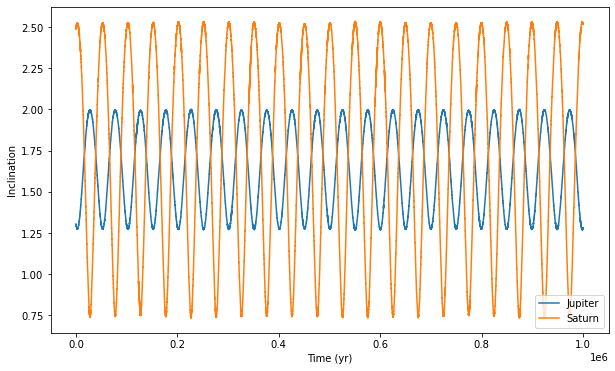

In [4]:
load_data = True

if load_data:
    tstep = 1
    tmax = 1e6 # end time of integration (yr)
    num_steps = int(tmax / tstep)

    file_path = f'j_s_incs_%.1E_yrs.pkl' % tmax

    ## open old data files
    with lzma.open(file_path, 'rb') as f:
        times, j_incs, s_incs = pickle.load(f)

fig = plt.figure(figsize=(10,6))

plt.plot(times, j_incs, label='Jupiter')
plt.plot(times, s_incs, label='Saturn')

plt.xlabel('Time (yr)')
plt.ylabel('Inclination')

plt.legend(loc='lower right')
plt.show()

# Decompose into sine waves

## Method 1: FFT

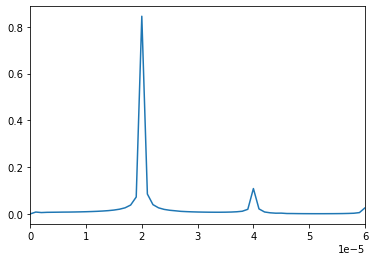

Period: 50000.0 years
Amplitude: 0.8455 degrees


In [17]:
N = num_steps

# only look at the positive side of the FFT
yf = np.abs(fft.fft(s_incs - np.mean(s_incs))[:N//2])
yf_scaled = 2 / num_steps * np.abs(yf)
xf = fft.fftfreq(num_steps, tstep)[:N//2]

plt.plot(xf, yf_scaled)

plt.xlim(0, 6e-5)
plt.show()

print(f'Period: {np.round(1 / (xf[np.argmax(yf)]), 3)} years')
print(f'Amplitude: {np.round(yf_scaled[np.argmax(yf)], 4)} degrees')

## FFT example

Looking at this example, I think the x-axis is frequency, not angular frequency; thus, period is 1/f not 2pi/f

In [ ]:
# # Number of sample points
# N = 600
# # sample spacing
# T = 1.0 / 800.0
# x = np.linspace(0.0, N*T, N, endpoint=False)
# y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
# yf = fft.fft(y)
# xf = fft.fftfreq(N, T)[:N//2]
# plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
# plt.grid()
# plt.show()

## Method 2: Quadratic interpolation w/ FFT result

In [ ]:
N = num_steps

# only look at the positive side of the FFT
yf = np.abs(fft.fft(j_incs - np.mean(j_incs))[:N//2])
yf_scaled = 2 / num_steps * np.abs(yf)
xf = fft.fftfreq(num_steps, tstep)[:N//2]

plt.plot(xf, np.abs(yf))

plt.xlim(0, 6e-5)
plt.show()

print(1 / (xf[np.argmax(yf)]))

In [13]:
x_vals = [xf[np.argmax(yf) - 1], xf[np.argmax(yf)], xf[np.argmax(yf) + 1]]
y_vals = np.abs([yf[np.argmax(yf) - 1], yf[np.argmax(yf)], yf[np.argmax(yf) + 1]])
y_vals_scaled = 2 / num_steps * np.abs(y_vals)

coeffs = np.polyfit(x_vals, y_vals_scaled, deg=2)

def quad_fn(coeffs, x):
    '''
    
    Given the coefficients of a quadratic polynomial f(x), return f(x).
    
    PARAMETERS
    ----------
    coeffs: 3-element list containing the quadratic's coefficients, 
    highest power first.
    x: the value at which to evaluate f(x).
    
    '''
    
    a, b, c = coeffs
    
    return a * x**2 + b * x + c

In [16]:
a, b, c = coeffs
max_f = - b / (2*a) # get peak of fitted quadratic
print(f'Period from FFT alone: {1 / xf[np.argmax(yf)]}')
print(f'Period from interpolated quadratic: {1 / max_f}')
print(f'Amplitude from interpolated quadratic: {np.round(quad_fn(coeffs, max_f), 4)} degrees')

Period from FFT alone: 50000.00000000001
Period from interpolated quadratic: 49989.603511532485
Amplitude from interpolated quadratic: 0.8455 degrees


# Analytic formula

I check that the mode frequency formula (Su & Lai 2022, Equation A2) matches our simulation's frequencies.

In [16]:
def laplace_coeff_integrand(x, alpha):
    '''
    
    This function represents the integrand of the Laplace coefficient formula
    (Eq. 6.67 of Murray & Dermott). Following Eq. A3 in Su & Lai 2022, we
    use j=1 and s=3/2. The result is used in the laplace_coeff function.
    
    PARAMETERS
    ----------
    x: argument of the function
    alpha: variable that isn't integrated over
    
    '''
    
    num = np.cos(x) # numerator
    denom = (1 - 2 * alpha * np.cos(x) + alpha**2) ** (3/2)
    
    return num / denom

def laplace_coeff(alpha):
    '''
    
    Calculate the Laplace coefficient using Eq. 6.67 of Murray & Dermott.
    (This is the exact form of Eq. A3 in Su & Lai 2022.) The result is used 
    in mode_freq (and is denoted as "b").
    
    PARAMETERS
    ----------
    alpha: input to the formula.
    
    '''
    
    return 1 / np.pi * integ.quad(laplace_coeff_integrand, 0, 2*np.pi, args=(alpha))[0]
    
def mode_freq(a_j, a_k, m_k, M_star):
    
    '''
    
    Calculate the precession rate (w_jk) of the j-th planet 
    induced by the k-th planet.
    
    PARAMETERS
    ----------
    a_j, a_k: semimajor axes of planets j and k, respectively; assumes that
    parameters are provided with units (e.g., u.au or u.m)
    m_k, M_star: masses of planet k and the central star, respectively; assumes
    that parameters are provided with units (e.g., u.kg or u.M_sun)
    
    '''
    # np.min, max don't work with astropy quantities
    a_min, a_max = a_j, a_k
    if (a_k < a_j):
        a_min = a_k
        a_max = a_j
        
    n_j = np.sqrt(const.G * M_star / (a_j**3))
    alpha = a_min / a_max
    b = laplace_coeff(alpha)
    
    return m_k / (4 * M_star) * \
            (a_j * a_min) / (a_max**2) * \
            n_j * b

In [34]:
a_jup = sim.particles[1].a * u.au
a_sat = sim.particles[2].a * u.au
m_jup = sim.particles[1].m * u.M_sun
m_sat = sim.particles[2].m * u.M_sun
M_sun = sim.particles[0].m * u.M_sun

# calculate w_jk values in yr^-1 (but without the unit)
w_js = mode_freq(a_jup, a_sat, m_sat, M_sun).to(u.yr**-1).value
w_sj = mode_freq(a_sat, a_jup, m_jup, M_sun).to(u.yr**-1).value

mat = np.array([
    [-w_js, w_js],
    [w_sj, -w_sj]
])

eigs, eigv = np.linalg.eig(mat)
prec_freq = eigs[np.where(np.abs(eigs) > 1e-10)[0]]

print(f'Period: {np.round(2 * np.pi / (w_js + w_sj), 3)} years')

Period: 50751.431 years


In [ ]:
alpha = a_jup / a_sat
laplace_coeff(alpha)

In [ ]:
# eq A3 in Su & Lai
3 * alpha * (1 + 15 * alpha**2 / 8 + 175/64 * alpha**4)